   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

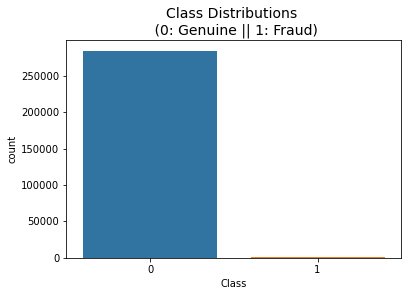

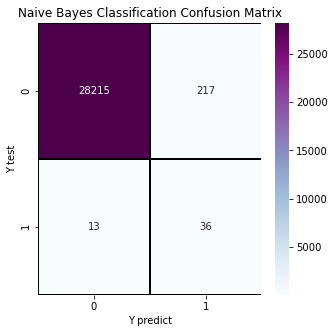

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

# Read data
data = pd.read_csv('data/creditcard.csv')
print(data.head())

# Check the data 
print("Credit card Fraud Detection data contains rows:", data.shape[0], "columns:", data.shape[1])

# Visulazing data 
sns.countplot('Class', data=data)
plt.title('Class Distributions \n (0: Genuine || 1: Fraud)', fontsize=14)

# Split data into training, validation, test set
y = data["Class"].values # our labels
X = data.drop(["Class"] ,axis=1).values # our features
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state=42, stratify=y) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=42, stratify=y)
print("fraud cases in test-set: ", sum(y_test))
print("The size of training set : ", len(y_train),"\nthe size of test set: ", len(y_test))

# Use Naive Bayes 
naive_bayes = GaussianNB()

# Training data 
naive_bayes.fit(X_train,y_train)

# Predict data 
y_pred = naive_bayes.predict(X_test)

# Get the accuracy of our training data 
accuracy_train = accuracy_score(y_train, naive_bayes.predict(X_train))
accuracy_test = accuracy_score(y_test, y_pred)

print("Accuracy training set is ", accuracy_train)
print("Accuracy testing set is ", accuracy_test)

# Print scores 
def print_scores(y_test,y_pred):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))

print_scores(y_test, y_pred)

# Get confusion matrix 
naive_bayes_confusion = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(naive_bayes_confusion, annot=True, linewidth=0.7, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Naive Bayes Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()